## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

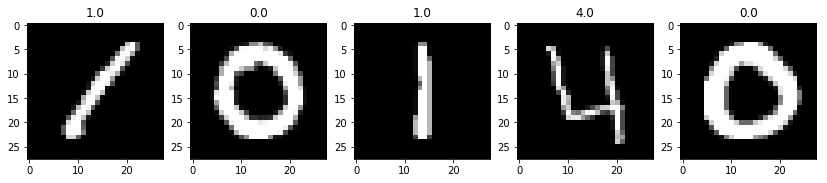

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [6]:
# Метод главных компонент

In [7]:
# выбираем семпл данных для обработки
choices = np.random.choice(train_img.shape[0], 10000)

y = train_label[choices]
X = train_img[choices].reshape(-1, 28 * 28).astype(np.float32)

X_train = train_img.reshape(-1, 28 * 28).astype(np.float32)
X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)

In [8]:
X.shape

(10000, 784)

In [9]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

In [10]:
X_mean.shape

(784,)

In [11]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [12]:
cov.shape

(784, 784)

In [13]:
U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

In [14]:
S[:10]

array([334219.4 , 251715.38, 212920.53, 188668.38, 167463.22, 144734.98,
       114554.75,  98061.66,  96424.68,  81954.78], dtype=float32)

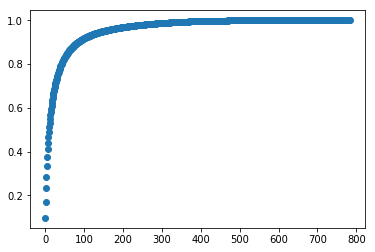

In [15]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [16]:
for i in range(5):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[000] 0.097
[001] 0.170
[002] 0.231
[003] 0.286
[004] 0.334


In [17]:
S_thr = 0.75  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=32 S=0.752


In [18]:
# получаем сжатое представление объектов
X_train_reduced = np.dot(X_train, U[:, :n_comp])

In [19]:
X_train_reduced.shape

(42000, 32)

In [20]:
X_test_reduced = np.dot(X_test, U[:, :n_comp])

In [21]:
X_test_reduced.shape

(28000, 32)

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [22]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [23]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [24]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [25]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

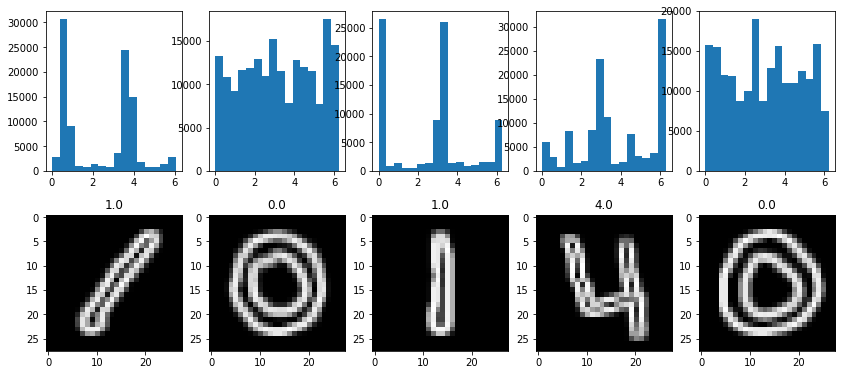

In [26]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [27]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [28]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [29]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [30]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [31]:
train = np.concatenate((train_hist, X_train_reduced), axis=1)

In [32]:
test = np.concatenate((test_hist, X_test_reduced), axis=1)

In [33]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train, test_size=0.2,
    random_state=42)

In [34]:
# Попробуем 3 разных модели

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [36]:
# Метод случайных соседей

In [37]:
knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=20)
knn.fit(x_train, y_train)
pred_val = knn.predict(x_val)
acc_knn = accuracy_score(y_val, pred_val)
           
print('Accuracy: %s' % acc_knn)

Accuracy: 0.9722619047619048


In [38]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       816
         1.0       0.98      1.00      0.99       909
         2.0       0.98      0.97      0.98       846
         3.0       0.98      0.96      0.97       937
         4.0       0.98      0.96      0.97       839
         5.0       0.96      0.97      0.96       702
         6.0       0.97      0.99      0.98       785
         7.0       0.97      0.96      0.97       893
         8.0       0.98      0.97      0.98       835
         9.0       0.94      0.96      0.95       838

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [39]:
print(confusion_matrix(y_val, pred_val))

[[811   0   0   0   0   2   3   0   0   0]
 [  0 907   0   0   0   0   2   0   0   0]
 [  6   5 823   1   1   0   1   8   1   0]
 [  1   1   8 898   0   9   1   5  10   4]
 [  1   2   0   0 805   0   5   1   0  25]
 [  0   1   0   8   0 678   8   0   2   5]
 [  4   0   0   0   0   5 775   0   1   0]
 [  0  11   5   2   2   1   0 859   0  13]
 [  1   1   4   3   3   6   2   2 809   4]
 [  2   2   2   7   7   4   0  12   0 802]]


In [40]:
pred_test = knn.predict(test)

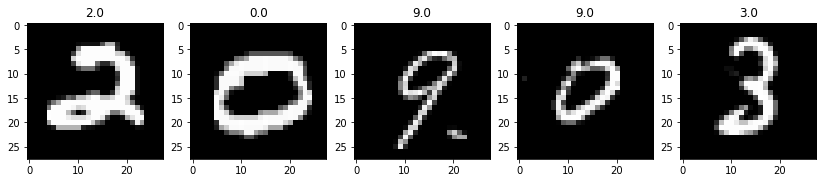

In [41]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [42]:
# Логистическая регрессия

In [43]:
logReg = LogisticRegression()
logReg.fit(x_train, y_train)
pred_val = logReg.predict(x_val)
acc_log = accuracy_score(y_val, pred_val)
           
print('Accuracy: %s' % acc_log)

D:\l\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\l\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.9108333333333334


In [44]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       816
         1.0       0.94      0.98      0.96       909
         2.0       0.91      0.88      0.89       846
         3.0       0.91      0.87      0.89       937
         4.0       0.90      0.93      0.92       839
         5.0       0.87      0.88      0.87       702
         6.0       0.93      0.95      0.94       785
         7.0       0.92      0.90      0.91       893
         8.0       0.90      0.88      0.89       835
         9.0       0.87      0.86      0.86       838

   micro avg       0.91      0.91      0.91      8400
   macro avg       0.91      0.91      0.91      8400
weighted avg       0.91      0.91      0.91      8400



In [45]:
print(confusion_matrix(y_val, pred_val))

[[802   0   0   0   1   2   7   1   2   1]
 [  1 888   4   0   1   0   2   2  11   0]
 [  3  13 742  18  17  13  10  10  19   1]
 [  2   7  27 814   1  39   3  11  19  14]
 [  1   4   2   0 781   0  12   0   4  35]
 [  5   5   5  28   6 617  16   1  14   5]
 [ 13   1   4   0   9   7 742   2   5   2]
 [  0   7  22   2  11   7   2 808   2  32]
 [  4  12   8  23   5  19   4   5 738  17]
 [  5   9   3  13  33   8   0  39   9 719]]


In [46]:
pred_test_1 = logReg.predict(test)

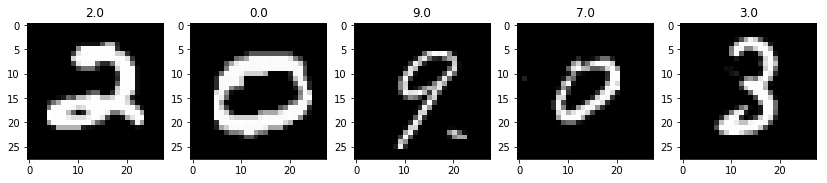

In [47]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test_1[i - 1]);

In [48]:
# Случайный лес

In [49]:
randomForest = RandomForestClassifier()
randomForest.fit(x_train, y_train)
pred_val = randomForest.predict(x_val)
acc_rf = accuracy_score(y_val, pred_val)
print('Accuracy: %s' % acc_rf)

D:\l\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9179761904761905


In [50]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       816
         1.0       0.98      0.98      0.98       909
         2.0       0.88      0.92      0.90       846
         3.0       0.89      0.89      0.89       937
         4.0       0.92      0.92      0.92       839
         5.0       0.88      0.90      0.89       702
         6.0       0.95      0.95      0.95       785
         7.0       0.94      0.92      0.93       893
         8.0       0.91      0.86      0.89       835
         9.0       0.90      0.86      0.88       838

   micro avg       0.92      0.92      0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400



In [51]:
print(confusion_matrix(y_val, pred_val))

[[795   0   6   1   4   2   5   0   2   1]
 [  1 894   3   1   3   0   3   2   0   2]
 [  9   1 780  18   3   8   6   3  17   1]
 [  2   0  31 833   0  33   2   7  21   8]
 [  3   1   4   4 771   1  13   6   2  34]
 [  4   0  19  26   1 635   6   5   5   1]
 [ 15   2   6   1   4  11 742   0   2   2]
 [  0   3  17   4   7   8   1 824   6  23]
 [ 15   3  18  33  10  20   5   4 719   8]
 [  8   5   7  17  37   5   2  25  14 718]]


In [52]:
pred_test_2 = randomForest.predict(test)

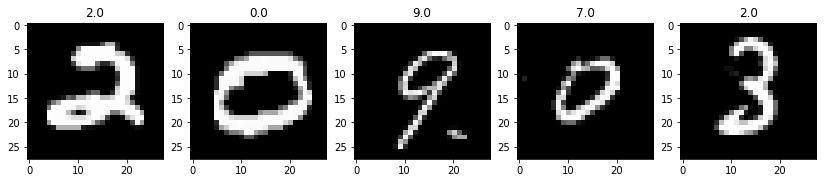

In [53]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test_2[i - 1]);

In [54]:
#Лучший результат у метода случайных соседей

## Готовим файл для отправки

In [55]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [56]:
!head submit.txt

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
